In [127]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numba import jit
import ar1_approx as ar
import time
from scipy.optimize import brentq
from math import sqrt
#np.set_printoptions(threshold=np.inf)
%matplotlib inline

# Problem 3

### Parameters

In [128]:
# Set parameters
alpha_k = 0.297
alpha_l = 0.65
delta = 0.154
psi = 1.08
w = 0.7
r= 0.04
betafirm = (1/(1+r))
# Parameters regarding shock
sigma_eps = 0.213
mu = 0.0
rho = 0.7605
sizez = 9

### Capital Stock Grid

In [129]:
# Discretizing the space of capital stock 
dens = 5
# put in bounds here for the capital stock space
kstar = ((((1 / betafirm - 1 + delta) * ((w / alpha_l) **
                                         (alpha_l / (1 - alpha_l)))) /
         (alpha_k * (1** (1 / (1 - alpha_l))))) **
         ((1 - alpha_l) / (alpha_k + alpha_l - 1)))
kbar = 3*kstar
lb_k = 0.001
ub_k = kbar
krat = np.log(lb_k / ub_k)
numb = np.ceil(krat / np.log(1 - delta))
K = np.zeros(int(numb * dens))
# we'll create in a way where we pin down the upper bound - since
# the distance will be small near the lower bound, we'll miss that by little
@jit
def create_K(numb,dens,delta,ub_k):
    for j in range(int(numb * dens)):
        K[j] = ub_k * (1 - delta) ** (j / dens)
    return K

K = create_K(numb,dens,delta,ub_k)
kvec = K[::-1]
sizek = kvec.shape[0]

### Productivity Shocks

In [130]:
# Find the Markov process for the shocks
z_grid, pi = ar.addacooper(sizez,mu,rho,sigma_eps)
z_grid = np.exp(z_grid) #make it to ln

### Profit and Cost Adjustment

In [131]:
def c_prime1(k_1,k_0,psi=1.08,delta=0.154):
    return psi*(k_1/k_0-(1-delta))

def c_prime2(k_1,k_0,psi=1.08,delta=0.154):
    return (psi/2)*((1-delta)**2-(k_1/k_0)**2)

def op_prime2(z,k,alpha_l=0.65,alpha_k=0.297,w=0.7):
    return (alpha_k * ((alpha_l / w) ** (alpha_l / (1 - alpha_l))) *
              (z**(1 / (1 - alpha_l)))*(k ** ((alpha_k/ (1 - alpha_l))-1)))

### Coleman Operator and Policy Function Iteration

In [132]:
def coleman_operator(g, kvec, beta, delta, c_prime1, c_prime2, op_prime2, pi, z_grid, sizez, sizek, Kg=None):
    """
    The approximate Coleman operator, which takes an existing guess g of the
    optimal consumption policy and computes and returns the updated function
    Kg on the grid points.  An array to store the new set of values Kg is
    optionally supplied (to avoid having to allocate new arrays at each
    iteration).  If supplied, any existing data in Kg will be overwritten.

    Parameters
    ----------
    g : array_like(float, ndim=2)
        The value of the input policy function on grid points
        Two dimensions to record optimal value given each shock
    kvec : array_like(float, ndim=1)
        The set of capital stock grid points
    beta : scalar
        The discount factor
    delta : scalar 
        The depreciation
    c_prime1 : function
        The derivative u'(c) of the utility function
    c_prime2 : function
        The production function f(k)
    op_prime2 : function
        The derivative f'(k)
    pi : numpy array (float, ndim=2)
        Transition matrix between shocks
    z_grid = numpy array (float, ndim=1)
        Array of possible shock values
    sizez : scalar
        Number of possible shock values
    sizek : scalar
        Size of kvec
    Kg : array_like(float, ndim=2) optional (default=None)
        Array to write output values to

    """
    # == Initialize Kg if necessary == #
    if Kg is None:
        Kg = np.empty_like(g)

    # == solve for updated consumption value
    for k in range(sizez):
        for i in range(sizek):
            # === Apply linear interpolation to g === #
            g_func = lambda x: np.interp(x, kvec, g[:,k])
            def h(y):
                expected = 0
                for j in range(sizez):
                    expected += pi[k,j]*op_prime2(z_grid[j],y)
                vals = expected + (1-delta) - c_prime2(g_func(y),y)
                return  1+c_prime1(y,kvec[i])-beta*vals
            k_star = brentq(h, 1e-10, 1e3)
            Kg[i,k] = k_star
    return Kg

In [133]:
def compute_pol(g_init, kvec, beta, delta, c_prime1, c_prime2, op_prime2, pi, z_grid, sizez, sizek, tol=1e-6, Kg=None):
    g_old = g_init
    err = 100
    iteration = 0
    while err > tol and iteration < 500:
        #print(g_old)
        g_new = coleman_operator(g_old, kvec, beta, delta, c_prime1, c_prime2, op_prime2, pi, z_grid, sizez, sizek)
        err = sqrt(np.sum(np.square(g_old-g_new)))
        g_old = g_new
        iteration += 1 
    print("Policy function converged after iteration number:", iteration)
    return g_new

In [134]:
g_init = np.zeros((sizek,sizez))
start_time = time.clock()
g = compute_pol(g_init, kvec, betafirm, delta, c_prime1, c_prime2, op_prime2, pi, z_grid, sizez, sizek)
time = time.clock() - start_time
print('PFI took ', time, ' seconds to solve')

Policy function converged after iteration number: 84
PFI took  76.34596800000003  seconds to solve


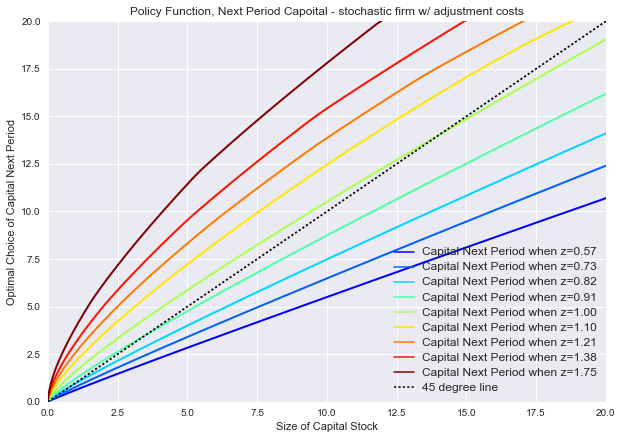

In [139]:
# Plot optimal capital stock rule as a function of firm size
fig, ax = plt.subplots(figsize=(10,7))
for k in range(sizez):
    lb = 'Capital Next Period when z='+format(z_grid[k],'.2f')
    ax.plot(kvec, g[:,k], color=plt.cm.jet((k+1)/sizez),lw=2,label=lb)
ax.plot(kvec, kvec, 'k:', label='45 degree line')
# Now add the legend with some customizations.
legend = ax.legend(loc='best', shadow=True)
# The frame is matplotlib.patches.Rectangle instance surrounding the legend.
frame = legend.get_frame()
frame.set_facecolor('0.90')
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Size of Capital Stock')
plt.axis([0,20,0,20])
plt.ylabel('Optimal Choice of Capital Next Period')
plt.title('Policy Function, Next Period Capoital - stochastic firm w/ ' +
          'adjustment costs')
plt.show()